C:\Users\aarjunan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


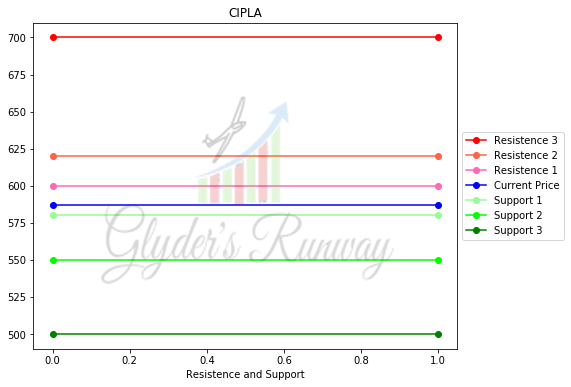

In [3]:
from datetime import date
from datetime import datetime
import calendar
import requests
from nsetools import Nse
nse=Nse()
from bs4 import BeautifulSoup
from pprint import pprint
from requests_html import HTMLSession
import json
import csv
import shutil
import pandas as pd
import time
#from options_list import options_stocks_list 
#Base_url="https://www1.nseindia.com/products/dynaContent/common/productsSymbolMapping.jsp?symbol=itc&segmentLink=3&symbolCount=2&series=EQ&dateRange=+&fromDate=30-04-2019&toDate=29-04-2020&dataType=PRICEVOLUMEDELIVERABLE"
Base_url="https://www.nseindia.com/api/option-chain-equities?symbol=CIPLA"
#Base_url="https://www.nseindia.com/api/option-chain-indices?symbol=BANKNIFTY"
session = HTMLSession()
    #print(Base_url)
resp = session.get(Base_url)
soup = BeautifulSoup(resp.html.html, 'html.parser')#soup = BeautifulSoup(page.content, 'html.parser')
data = json.loads(str(soup))
expiry_dates=data['records']['expiryDates']
expiry_day=expiry_dates[0]
if((datetime.strptime(expiry_day, '%d-%b-%Y').date() <= datetime.today().date())):
    expiry_day=expiry_dates[1]
CE_data=[]
PE_data=[]

for i in range(1,len(data['records']['data'])-1):
    if(data['records']['data'][i]['expiryDate'] == expiry_day):
        if('CE' in data['records']['data'][i].keys()):
            CE_data.append(data['records']['data'][i]['CE'])
        if('PE' in data['records']['data'][i].keys()):
            PE_data.append(data['records']['data'][i]['PE'])
        
def get_levels(option_chain,CE_or_PE):
    df_option=pd.DataFrame(option_chain)
    drop_list = ['underlyingValue','changeinOpenInterest','identifier', 'underlying','pchangeinOpenInterest']
    drop_list = drop_list + ['bidQty','bidprice','change','expiryDate']
    df=df_option
    if CE_or_PE == 1:
        df=df_option[df_option.strikePrice > df_option.underlyingValue].head(15).drop(drop_list, axis=1)
        df=df.set_index('openInterest').sort_index(ascending=False).head(3)
    else:
        df=df_option[df_option.strikePrice < df_option.underlyingValue].tail(15).drop(drop_list, axis=1)
        df=df.set_index('openInterest').sort_index().tail(3)   
    
    df['oi'] = df.index   
    df=df.set_index('strikePrice').sort_index(ascending=False)
       
    return df.index.to_list(),list(df['oi']) 
    
CE_levels, CE_OI = get_levels(CE_data,1)
PE_levels, PE_OI = get_levels(PE_data,0)
underlying=int(data['records']['data'][0]['CE']['underlyingValue'])

import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import matplotlib.image as image
from PIL import Image
import numpy as np

x = np.arange(10)
with cbook.get_sample_data('c:\\Personal\\Finance\\Stocks\\Trading\\Scripting\\GlydersRunway.png') as file:
    im = Image.open(file)
    im = im.resize((325, 325), Image.ANTIALIAS)
    #im.resize((160, 240))
    
def plot_levels(symbol,price,R,R_oi,S,S_oi):
    P=[price,price]
    
    plt.figure(figsize=(9.5,6))
    
    plt.plot([R[0],R[0]], color='r', label = "Resistence 3",marker='o')
    plt.plot([R[1],R[1]], color='tomato', label = "Resistence 2",marker='o')
    plt.plot([R[2],R[2]], color='hotpink', label = "Resistence 1",marker='o')
    plt.plot(P, color='b',label = "Current Price",marker='o')
    plt.plot([S[0],S[0]], color='palegreen', label = "Support 1",marker='o')
    plt.plot([S[1],S[1]], color='lime', label = "Support 2",marker='o')
    plt.plot([S[2],S[2]], color='g', label = "Support 3",marker='o')
    #plt.xlabel('Date')
    plt.xlabel('Resistence and Support')
    plt.title(symbol)
    
    ax = plt.subplot(111)
    #for i in range(5):
        #ax.plot(x, i * x, label='$y = %ix$'%i)
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))    
    
    # show a legend on the plot
    #plt.legend()
    plt.figimage(im, 85, 35, zorder=70, alpha=0.20)
    filename="c:\\Personal\\" + symbol + "_Levels.png"
    plt.savefig(filename)
    plt.plot()
    #plt.close('all')
    
    
plot_levels('CIPLA',underlying,CE_levels, CE_OI, PE_levels, PE_OI)